In [11]:
import os
import sys
import torch
from transformers import BertTokenizer
import lightning as pl

In [12]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))  
os.path.abspath(os.path.join(os.getcwd(), os.pardir))

'/home/zhulin/workspace/Jack'

In [13]:
pl.seed_everything(42, workers=True)
torch.set_float32_matmul_precision(precision="high")

Seed set to 42


In [14]:
args = {
    "pretrain": '/home/zhulin/pretrain/bert_pretrain_uncased/',
    "model": "/home/zhulin/models/single_channel_transformer.ckpt",
    "dataset": "/mnt/sdd1/data/zhulin/jack/cdatasets.test.5.csv"
}

In [15]:
### load model
from core.predictor import SingleChannelPredictor
tokenizer = BertTokenizer.from_pretrained(args["pretrain"], use_fast=True)

ckpt = torch.load(args["model"])
predictor = SingleChannelPredictor(**ckpt["hyper_parameters"])
predictor.load_state_dict(ckpt["state_dict"])
predictor = predictor.eval().cuda()

In [16]:
for name, module in predictor.named_modules():
    print(name)


net
net.input_net
net.input_net.0
net.input_net.1
net.input_net.2
net.positional_encoding
net.transformer
net.transformer.layers
net.transformer.layers.0
net.transformer.layers.0.attn
net.transformer.layers.0.attn.qkv_proj
net.transformer.layers.0.attn.o_proj
net.transformer.layers.0.linear_net
net.transformer.layers.0.linear_net.0
net.transformer.layers.0.linear_net.1
net.transformer.layers.0.linear_net.2
net.transformer.layers.0.linear_net.3
net.transformer.layers.0.norm1
net.transformer.layers.0.norm2
net.transformer.layers.0.dropout
net.pooling_net
net.output_net
net.output_net.0
net.output_net.1
net.output_net.2
net.output_net.3


In [17]:
### load extractor
from common.extractor import FeatureExtractor

extractor = FeatureExtractor()
extractor.register(predictor, [
    "net.input_net.0",                      # nn.Embedding
    "net.input_net.2",                      # nn.Linear
    "net.transformer.layers.0.norm1",       
    "net.pooling_net",                      # nn.MultiheadAttention
    "net.output_net.1",                     # nn.Linear
])

In [18]:
### load dataset
import numpy as np
import pandas as pd
import datatable as dt

data = dt.fread(args["dataset"], fill=True)
data = data[dt.f.index == "k5c7fb0927db37372da25f270708103a2", :]
data.head(3)

,index,unique_key,pid,pname,label,channel,cnt
,▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪,▪▪▪▪,▪,▪▪▪▪▪▪▪▪,▪▪▪▪
0,k5c7fb0927db37372da25f270708103a2,−1,1848,WMIADAP.exe,1,RegistryQueryValue ThrottleDrege RegistryQueryValue ThrottleDrege RegistryQueryValue ThrottleDrege R…,8
1,k5c7fb0927db37372da25f270708103a2,−1,1848,WMIADAP.exe,1,RegistryQueryValue ThrottleDrege RegistryQueryValue ThrottleDrege RegistryQueryValue ThrottleDrege R…,8
2,k5c7fb0927db37372da25f270708103a2,−1,1848,WMIADAP.exe,1,RegistryQueryValue ThrottleDrege RegistryQueryValue ThrottleDrege RegistryQueryValue ThrottleDrege R…,8


In [20]:
from tqdm import tqdm

extractor.features.clear()
predictor = predictor.eval().cuda()
for i in tqdm(range(data.nrows)):
    padded_sent_seq = tokenizer(data[i, 5], padding=True, truncation=True, max_length=2048, return_tensors="pt")
    data_length = torch.tensor([sum(mask) for mask in padded_sent_seq["attention_mask"]])

    with torch.no_grad():
        pred = predictor(padded_sent_seq["input_ids"].cuda(), padded_sent_seq["attention_mask"].cuda(), data_length)

100%|██████████| 42698/42698 [04:38<00:00, 153.55it/s]


In [21]:
net_input_net_0 = torch.cat([x.mean(dim=1) for x in extractor.features["net.input_net.0"]])
net_input_net_2 = torch.cat([x.mean(dim=1) for x in extractor.features["net.input_net.2"]])
net_transformer_layers_0_norm1 = torch.cat([x.mean(dim=1) for x in extractor.features["net.transformer.layers.0.norm1"]])
net_pooling_net = torch.cat(extractor.features["net.pooling_net"])
net_output_net_1 = torch.cat(extractor.features["net.output_net.1"])

/tmp/ipykernel_23492/3851481585.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x[indices, 0], x[indices, 1], c=colors[label], label=label, cmap=colors, s=5, alpha=0.3)
/tmp/ipykernel_23492/3851481585.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x[indices, 0], x[indices, 1], c=colors[label], label=label, cmap=colors, s=5, alpha=0.3)
/tmp/ipykernel_23492/3851481585.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x[indices, 0], x[indices, 1], c=colors[label], label=label, cmap=colors, s=5, alpha=0.3)
/tmp/ipykernel_23492/3851481585.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x[indices, 0], x[indices, 1], c=colors[label], label=label, cmap=colors, s=5, alpha=0.3)
/tmp/ipykernel_23492/3851481585.py:17: UserWarning: No data for colormapping

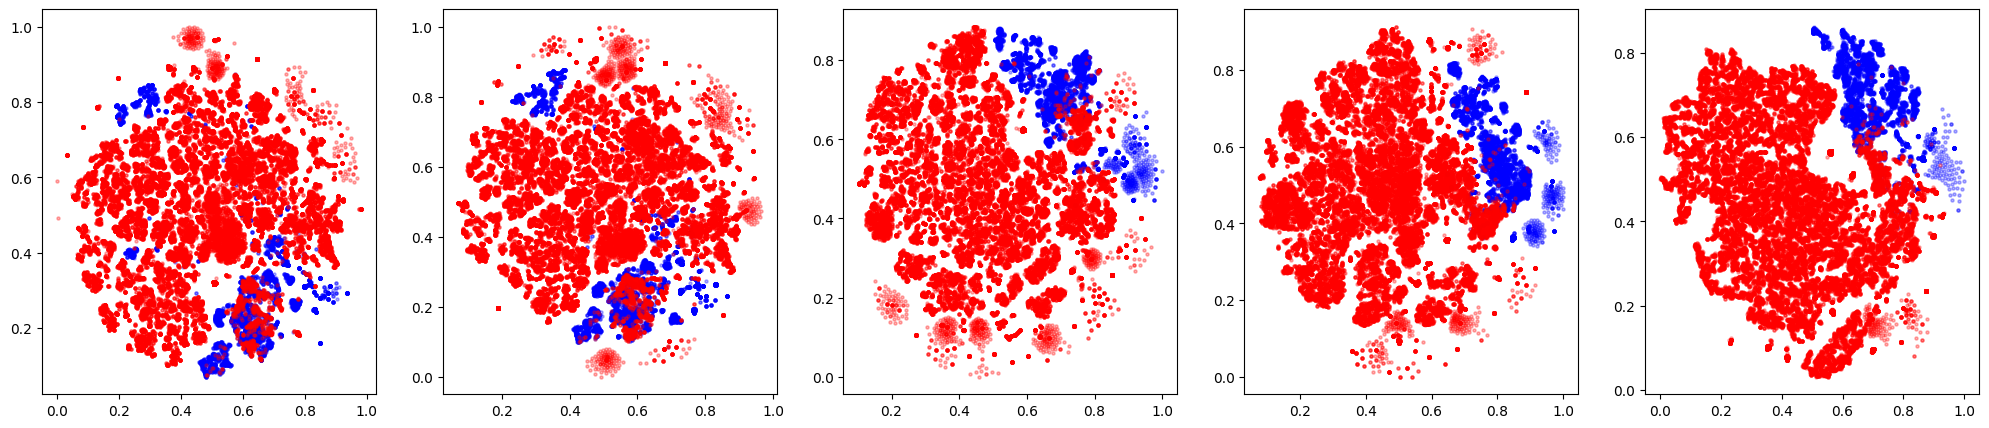

In [23]:
## t-sne降维分析
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

def draw_tsne_scatter_density(ax, x, y, labels):
    tsne = TSNE(n_components=2)
    x = tsne.fit_transform(x)  
    x = (x - np.min(x)) / (np.max(x) - np.min(x))
    density = gaussian_kde(x.T)(x.T)
    # cmap = plt.cm.get_cmap('viridis')
    # 使用字典存储颜色，以便为每个类别分配唯一颜色
    colors = {0: 'blue', 2: 'green', 1: 'red'}
    for label in set(labels):
        indices = np.argwhere(y == label)
        ax.scatter(x[indices, 0], x[indices, 1], c=colors[label], label=label, cmap=colors, s=5, alpha=0.3)

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
draw_tsne_scatter_density(axes[0], net_input_net_0.cpu().numpy(), data[:, dt.f.label].to_numpy().flatten(), [1, 0])
draw_tsne_scatter_density(axes[1], net_input_net_2.cpu().numpy(), data[:, dt.f.label].to_numpy().flatten(), [1, 0])
draw_tsne_scatter_density(axes[2], net_transformer_layers_0_norm1.cpu().numpy(), data[:, dt.f.label].to_numpy().flatten(), [1, 0])
draw_tsne_scatter_density(axes[3], net_pooling_net.cpu().numpy(), data[:, dt.f.label].to_numpy().flatten(), [1, 0])
draw_tsne_scatter_density(axes[4], net_output_net_1.cpu().numpy(), data[:, dt.f.label].to_numpy().flatten(), [1, 0])
plt.show(fig)
